The imports:

In [7]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from xrayproject.utils import load_train, load_masks
from xrayproject.preprocessing import normalize, flip_resize, resize_test
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Section 0.1: Calling funtions from previous modules/.py files in the xrayproject-project:

In [8]:
path_image = '../raw_data/raw_PRC/CXR_png/'
path_mask = '../raw_data/raw_PRC/CXR_mask/'

masks, targets, ID = load_masks(100, get_all = False, get_random = True, balanced = True, path = path_mask)

Using path:  ../raw_data/raw_PRC/CXR_mask/
Using bucket 
Loading local file:  ../raw_data/raw_PRC/CXR_mask/CHNCXR_0476_1_mask.png
Loading local file:  ../raw_data/raw_PRC/CXR_mask/CHNCXR_0601_1_mask.png
Loading local file:  ../raw_data/raw_PRC/CXR_mask/CHNCXR_0640_1_mask.png
Loading local file:  ../raw_data/raw_PRC/CXR_mask/CHNCXR_0568_1_mask.png
Loading local file:  ../raw_data/raw_PRC/CXR_mask/CHNCXR_0610_1_mask.png
Loading local file:  ../raw_data/raw_PRC/CXR_mask/CHNCXR_0376_1_mask.png
Loading local file:  ../raw_data/raw_PRC/CXR_mask/CHNCXR_0468_1_mask.png
Loading local file:  ../raw_data/raw_PRC/CXR_mask/CHNCXR_0430_1_mask.png
Loading local file:  ../raw_data/raw_PRC/CXR_mask/CHNCXR_0367_1_mask.png
Loading local file:  ../raw_data/raw_PRC/CXR_mask/CHNCXR_0648_1_mask.png
Loading local file:  ../raw_data/raw_PRC/CXR_mask/CHNCXR_0443_1_mask.png
Loading local file:  ../raw_data/raw_PRC/CXR_mask/CHNCXR_0445_1_mask.png
Loading local file:  ../raw_data/raw_PRC/CXR_mask/CHNCXR_0370_1_mas

In [9]:
1+1

2

In [10]:
images, IDs = load_train(ID, path = path_image)

Loading local file:  ../raw_data/raw_PRC/CXR_png/CHNCXR_0286_0.png
Loading local file:  ../raw_data/raw_PRC/CXR_png/CHNCXR_0246_0.png
Loading local file:  ../raw_data/raw_PRC/CXR_png/CHNCXR_0382_1.png
Loading local file:  ../raw_data/raw_PRC/CXR_png/CHNCXR_0476_1.png
Loading local file:  ../raw_data/raw_PRC/CXR_png/CHNCXR_0006_0.png
Loading local file:  ../raw_data/raw_PRC/CXR_png/CHNCXR_0399_1.png
Loading local file:  ../raw_data/raw_PRC/CXR_png/CHNCXR_0610_1.png
Loading local file:  ../raw_data/raw_PRC/CXR_png/CHNCXR_0594_1.png
Loading local file:  ../raw_data/raw_PRC/CXR_png/CHNCXR_0081_0.png
Loading local file:  ../raw_data/raw_PRC/CXR_png/CHNCXR_0161_0.png
Loading local file:  ../raw_data/raw_PRC/CXR_png/CHNCXR_0225_0.png
Loading local file:  ../raw_data/raw_PRC/CXR_png/CHNCXR_0508_1.png
Loading local file:  ../raw_data/raw_PRC/CXR_png/CHNCXR_0321_0.png
Loading local file:  ../raw_data/raw_PRC/CXR_png/CHNCXR_0535_1.png
Loading local file:  ../raw_data/raw_PRC/CXR_png/CHNCXR_0020_0

In [11]:
print(images[1].shape)

(2988, 2698, 3)


In [12]:
2897/2499

1.1592637054821928

In [13]:
print(images[1].shape)
# resized = [flip_resize(images[i], masks[i], input_shape=(4*116, 4*100)) for i in range(len(images))]
resized = [flip_resize(images[i], masks[i], input_shape=(128, 128)) for i in range(len(images))]
print(resized[0][0].shape)

(2988, 2698, 3)
(128, 128, 3)


(2988, 2698, 3)


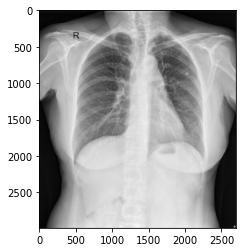

(128, 128, 3)


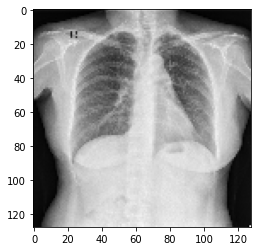

(2988, 2698, 1)


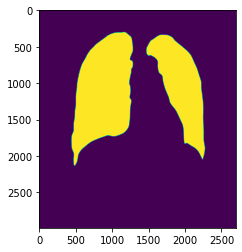

(128, 128, 1)


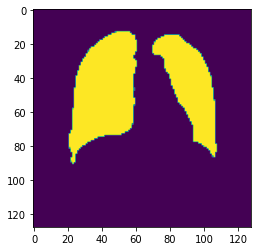

In [14]:
print(images[1].shape)
plt.imshow(images[1])
plt.show()

print(resized[1][0].shape)
plt.imshow(resized[1][0])
plt.show()

print(masks[1].shape)
plt.imshow(masks[1])
plt.show()

print(resized[1][1].shape)
plt.imshow(resized[1][1])
plt.show()

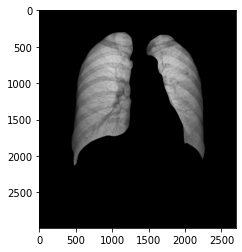

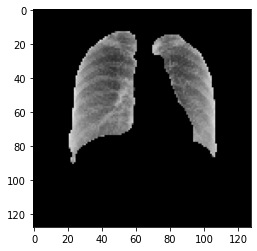

In [15]:
plt.imshow(masks[1]*images[1])
plt.show()
plt.imshow(resized[1][0]*resized[1][1])
plt.show()

### Implementing a train-test split. Not sure this is needed...

In [16]:
print(resized[0][0].shape,\
      resized[0][1].shape,\
      resized[0][2].shape,\
      resized[0][3].shape)

(128, 128, 3) (128, 128, 1) (128, 128, 3) (128, 128, 1)


200
200


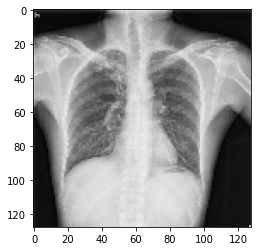

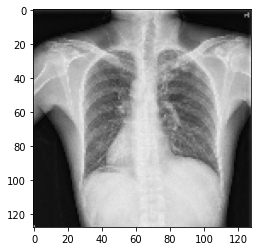

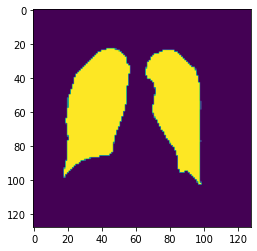

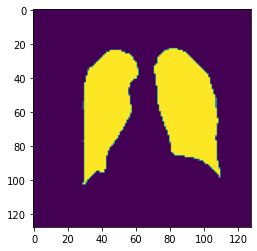

In [17]:
X_1 = [img_mask_pair[0] for img_mask_pair in resized]
X_2 = [img_mask_pair[2] for img_mask_pair in resized]

Y_1 = [img_mask_pair[1] for img_mask_pair in resized]
Y_2 = [img_mask_pair[3] for img_mask_pair in resized]

X = X_1 + X_2
Y = Y_1 + Y_2

X = np.array(X)
Y = np.array(Y)

# X = tuple(X)
# Y = tuple(Y)

print(len(X))
print(len(Y))

plt.imshow(X[10])
plt.show()

plt.imshow(X[110])
plt.show()

plt.imshow(Y[10])
plt.show()

plt.imshow(Y[110])
plt.show()

In [18]:
np.shape(X_1)
type(np.array(X_1))
type(X_1[0])

tensorflow.python.framework.ops.EagerTensor

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

In [20]:
print(X_test.shape, X_train.shape)
print(Y_test.shape, Y_train.shape)

(60, 128, 128, 3) (140, 128, 128, 3)
(60, 128, 128, 1) (140, 128, 128, 1)


### Using some stolen plotting-functions, etc.:

In [21]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

### Defining the model (stolen direclty from <https://www.tensorflow.org/tutorials/images/segmentation>):

**Note**: The models in this section seem to want square images. So I will make them square. Currently, I see two "safe" ways to do this:

1. Utilizing the tensorflow-method tf.image.resize_with_pad, one can simply resize all images to squares by adding blank-space to make them square. This sounds innocuous, but will certainly increase the "class imbalance, which *could* be problematic.

2. Simply resizing the images to squares. This also has pros and cons. Pro: The class imbalances will remain fixed/minimally horrible. Con: It will distort the images, which may degrade image-recognition.

FYI: <https://www.tensorflow.org/api_docs/python/tf/image/resize_with_pad>

In [22]:
OUTPUT_CHANNELS = 1

**Important**: When the model _MobileNetV2_ is instantiated, _tensorflow_ gives error-messages unless two conditions are simulanteously met by the input_shape-parameter:

1. The input_shape is non-square. (We knew this. See above markup-cell.)
2. The input_shape is a square with dimensions other than (224, 224), (128, 128) etc. etc. The largest of these is (224, 224)-shape. But with (224, 224) there were problems --- maybe with the dimensionality of the "layer_names"-feature of the base_model (below). So I have chosen to futz that over to (128, 128)-shape for the time being...

In [23]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [24]:
from tensorflow_examples.models.pix2pix import pix2pix

up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [25]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 2, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

### Running the model (stolen directly and modified _zero_ (will it work at all??))...

In [26]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [28]:
# class DisplayCallback(tf.keras.callbacks.Callback):
#   def on_epoch_end(self, epoch, logs=None):
#     clear_output(wait=True)
#     show_predictions()
#     print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [29]:
len(resized[1])

4

In [30]:
TRAIN_LENGTH = len(X_test)
BATCH_SIZE = 5
BUFFER_SIZE = 10
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [31]:
x_train = tf.image.rgb_to_grayscale(X_train)
x_test = tf.image.rgb_to_grayscale(X_test)

In [32]:
train_dataset = (x_train, Y_train)
test_dataset = (x_test, Y_test)

In [33]:
np.shape(train_dataset)

(2, 140, 128, 128, 1)

In [34]:
np.shape(X_train)

(140, 128, 128, 3)

In [35]:
Y_train.shape

(140, 128, 128, 1)

In [ ]:
EPOCHS = 5
VAL_SUBSPLITS = 5
VALIDATION_STEPS = len(X_test)//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(X_train, Y_train, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS#,
                          #validation_data=(X_test, Y_test),
#                           callbacks=[DisplayCallback()]
                         )

Epoch 1/5
12/12 [==============================] - 27s 1s/step - loss: 0.5249 - accuracy: 0.7569
Epoch 2/5
12/12 [==============================] - 13s 1s/step - loss: 0.3038 - accuracy: 0.8141
Epoch 3/5
12/12 [==============================] - 13s 1s/step - loss: 0.2138 - accuracy: 0.9116
Epoch 4/5
 8/12 [===================>..........] - ETA: 4s - loss: 0.1680 - accuracy: 0.9453